<a href="https://colab.research.google.com/github/asanth7/SP500-news-prediction/blob/main/StockPrediction_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, LSTM, Flatten, Bidirectional, Dropout
from keras.layers.normalization.batch_normalization import BatchNormalization
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from gc import callbacks
import numpy as np
from torch.utils.data import Dataset
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools
import csv
import nltk
import string
from copy import deepcopy
import pandas as pd


nltk.download('stopwords')
from nltk.corpus import stopwords

STOPWORDS = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def load_data(file_path):
    if file_path is None:
        return "No filepath found"

    labels = []
    headlines_per_day = []
    with open(file_path, "r") as file:
      reader = csv.reader(file, delimiter=',')
      next(reader, None)
      # next(reader, None)
      for row in reader:
          convertedRow = [label_or_headline for label_or_headline in row]
          labels.append(convertedRow[0])
          # print(convertedRow[1:])
          headlines_per_day.append(convertedRow[1:])

      file.close()

      # Checks if headline is type byte from csv file, if so, decodes to string for cleaning and tokenization

      for day in headlines_per_day:
          for headline in day:
              # print(type(headline))
              if isinstance(headline, bytes):
                  headline = headline.decode()

      int_labels = [int(label) for label in labels]


    return headlines_per_day, int_labels

In [ ]:
file_path = r'/content/S&P500_RedditNews_labeled_data_multiclassfinal.csv'
headlines, labels = load_data(file_path)
X_train, X_test, y_train, y_test = train_test_split(headlines, labels, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2)

In [ ]:
def clean(headline):
    nopunct = headline.translate(str.maketrans('', '', string.punctuation))
    nostop = [word for word in nopunct.split(' ') if word not in STOPWORDS]
    clean_sentence = [word.lower() for word in nostop]
    return clean_sentence

In [ ]:
X_train_token = [clean(headline) for day in X_train for headline in day]
X_val_token = [clean(headline) for day in X_val for headline in day]

In [ ]:
X_test_token = [clean(headline) for day in X_test for headline in day]

In [ ]:
max_len = 0
for phrase in X_train_token:
    if len(phrase) > max_len:
         max_len = len(phrase)
for phrase in X_val_token:
    if len(phrase) > max_len:
        max_len = len(phrase)
for phrase in X_test_token:
    if len(phrase) > max_len:
        max_len = len(phrase)

In [ ]:
max_len

47

In [ ]:
def buildVocabulary(X_train_token, X_val_token):

    list_sequence = X_train_token + X_val_token
    all_words = []
    for phrase in list_sequence:
      for word in phrase:
          word = word.strip('\n')
          all_words.append(word)

    unique_words = set(all_words)
    print(len(unique_words))

    word_count = {}
    for word in unique_words:
      print(word)
      word_count[word] = all_words.count(word)
    print('created word_count')

    word2ind = {word: i for i, word in enumerate(unique_words, start=1)}
    vocab_size = len(word2ind)
    print('created word2ind')

    return word_count, word2ind, vocab_size

In [ ]:
word_count, word2ind, vocab_size = buildVocabulary(X_train_token, X_val_token)

Streaming output truncated to the last 5000 lines.
markets
miscarriages
mitchell
minerva
exmicrosoft
abdomens
animated
disillusioned
pollard
trooper
crisisstruck
787
sciences
quarters
engenders
plantation
childrenwomen
documentation
agarwal
wrongs
64magnitude
southeast
saucepanwielding
mint
sarath
rtaiwan
200kg
norwegian
enlighten
1142
ecstasys
weirder
primer
afridi
tea
paddies
democratically
summarizing
bagcarrying
wooden
ads
aldrich
mickey
heal
commanders
antiausterity
wasting
giraffe
crashing
egomaniac
oversees
prisons
bahrain
griffin
moscows
zanardi
combine
needs
transportion
explodes
ritually
manufacture
difficulties
3855
tailed
renewed
brave
narcoterrorists
sewageladen
previously
boatmen
numb
rapture
concert
inevitably
empower
rnmoon
weeklys
antidiscrimination
barbaric
prop
prints
navys
rae
critized
pudding
orleans
housetohouse
7800
reclamation
slight
intel
ea
ussponsored
earlystage
easa
current
stalin
stationed
manpads
penn
equality
deforested
knights
czech
louboutin
dweller
inc

In [ ]:
def vectorize(tokens, max_len, word2ind):
    '''
    :param tokens:
    :param max_len:
    :param word2ind:
    :return: 1D numpy array (length = max)len)
    '''

    if tokens is None:
        return "No tokens found"
    if max_len is None:
        return "No max_len provided"
    if word2ind is None:
        return "No word2ind found"

    sentence = np.zeros(max_len)
    position = 0
    for token in tokens:
        index = word2ind.get(token, 0)
        sentence[position] = index
        position += 1

    return sentence


In [ ]:
X_train_array = np.array([vectorize(tokens, max_len, word2ind) for tokens in X_train_token])
X_val_array = np.array([vectorize(tokens, max_len, word2ind) for tokens in X_val_token])
print('train and val arrays done')
assert X_train_array.shape[-1] == max_len
print(X_train_array.shape)
print(X_val_array.shape)

train and val arrays done
(29825, 47)
(9950, 47)


In [ ]:
X_test_array = np.array([vectorize(tokens, max_len, word2ind) for tokens in X_test_token])
print(X_test_array.shape)

(9950, 47)


In [ ]:
X_train_array.shape

(29825, 47)

In [ ]:
from tensorflow.keras.utils import to_categorical

def convert2onehot(labels, num_classes):

  # onehots = to_categorical(labels, num_classes=num_classes)
  # print(onehots[:10])

  # return onehots

    if labels is None:
        return "No labels found"

    num_repeats = 25
    labels = np.repeat(labels, num_repeats)
    print(len(labels))

    final = []
    start = []
    for i in range(num_classes):
        start.append(0)

    for label in labels:
        values = deepcopy(start)
        values[label] = 1
        final.append(values)
    return np.array(final)

In [ ]:
y_train_onehot = convert2onehot(y_train, 6)
y_val_onehot = convert2onehot(y_val, 6)
y_test_onehot = convert2onehot(y_test, 6)
print('onehots done')
assert y_train_onehot.shape[1] == 6

29825
9950
9950
onehots done


In [ ]:
print(X_train_array.shape)
print(y_train_onehot.shape)
print(X_val_array.shape)
print(y_val_onehot.shape)
print(X_test_array.shape)
print(y_test_onehot.shape)

print(X_train_array)
print('\n')
print(y_train_onehot)

(29825, 47)
(29825, 6)
(9950, 47)
(9950, 6)
(9950, 47)
(9950, 6)
[[28783.   113. 14267. ...     0.     0.     0.]
 [22090. 11895. 31479. ...     0.     0.     0.]
 [ 1379. 22674. 30547. ...     0.     0.     0.]
 ...
 [19587.  1810.  1689. ...     0.     0.     0.]
 [ 3073. 26076.  2862. ...     0.     0.     0.]
 [12140. 24117. 21247. ...     0.     0.     0.]]


[[0 0 1 0 0 0]
 [0 0 1 0 0 0]
 [0 0 1 0 0 0]
 ...
 [0 0 0 1 0 0]
 [0 0 0 1 0 0]
 [0 0 0 1 0 0]]


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

def set_class_weights():
    label_integers = np.argmax(np.array(y_train_onehot), axis=1)
    class_weights = compute_class_weight('balanced', classes=np.unique(label_integers), y=label_integers)
    class_weights = dict(enumerate(class_weights))
    print('Class weights:', class_weights)
    return class_weights

class_weights = set_class_weights()

Class weights: {0: 19.883333333333333, 1: 4.518939393939394, 2: 0.4212570621468927, 3: 0.3212170166935918, 4: 5.373873873873874, 5: 18.075757575757574}


In [ ]:
num_classes = 6

stock_model = keras.Sequential([
    Embedding(vocab_size + 1, 64, input_length=max_len),
    LSTM(units=96, input_shape=(X_train_array.shape[0], X_train_array.shape[1]), return_sequences=True),
    LSTM(units=32),
    #BatchNormalization(),
    Dropout(0.05),
    Dense(units=16, activation='relu'),
    #BatchNormalization(),
    Dropout(0.05),
    Dense(units=8, activation='relu'),
    #BatchNormalization(),
    Dropout(0.05),
    Dense(units=num_classes, activation='softmax')
])

stock_model.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)

adam_opt = keras.optimizers.Adam(learning_rate=0.0001)

stock_model.compile(optimizer=adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])
history = stock_model.fit(X_train_array, y_train_onehot, batch_size=4, epochs=2, validation_data=(X_val_array, y_val_onehot),
                          class_weight=class_weights, shuffle=True, callbacks=[callback], verbose=1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 47, 64)            2044416   
                                                                 
 lstm_6 (LSTM)               (None, 47, 96)            61824     
                                                                 
 lstm_7 (LSTM)               (None, 32)                16512     
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 16)                528       
                                                                 
 dropout_10 (Dropout)        (None, 16)                0         
                                                                 
 dense_10 (Dense)            (None, 8)                

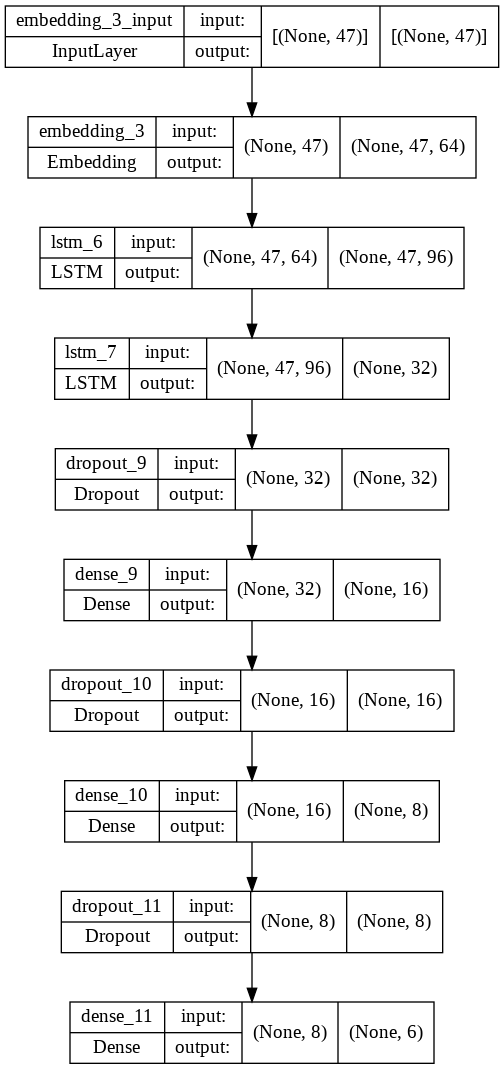

In [ ]:
tf.keras.utils.plot_model(stock_model, show_shapes=True, show_layer_names=True)

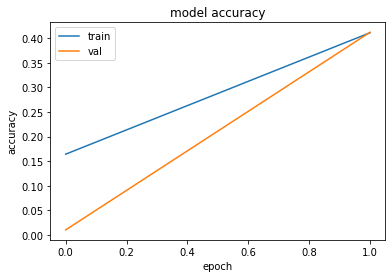

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

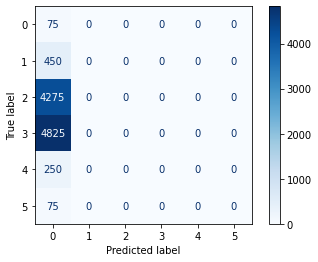

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import to_categorical

y_pred = stock_model.predict(X_test_array)
#print(y_pred[:5])

#y_pred = y_pred.flatten()
#print(test_df['Headline'].tolist()[:10])
#p_pred = p_pred.round(2)

y_pred = np.where(y_pred > 0.5, 1, 0).argmax(axis=1)
#print('New y_pred: ')
#print(y_pred[:5])

#print(y_pred_final[:5])
y_test = np.array(y_test_onehot).argmax(axis=1)

#print(y_test[:5])

#labels = [str(label) for label in np.argmax(np.array(y_train_onehot), axis=1)]
labels = ["0", "1", "2", "3", "4", "5"]
#labels = ["0", "1"]

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
# BEST MULTICLASS - 41% ACCURACY

# num_classes = 6

# stock_model = keras.Sequential([
#     Embedding(vocab_size + 1, 64, input_length=max_len),
#     LSTM(units=96, input_shape=(X_train_array.shape[0], X_train_array.shape[1]), return_sequences=True),
#     LSTM(units=32),
#     #BatchNormalization(),
#     Dropout(0.1),
#     Dense(units=16, activation='relu'),
#     #BatchNormalization(),
#     Dropout(0.1),
#     Dense(units=8, activation='relu'),
#     #BatchNormalization(),
#     Dropout(0.05),
#     Dense(units=num_classes, activation='softmax')
# ])

# stock_model.summary()

# callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)

# adam_opt = keras.optimizers.Adam(learning_rate=0.0001)

# stock_model.compile(optimizer=adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])
# history = stock_model.fit(X_train_array, y_train_onehot, batch_size=4, epochs=2, validation_data=(X_val_array, y_val_onehot),
#                           class_weight=class_weights, shuffle=True, callbacks=[callback], verbose=1)

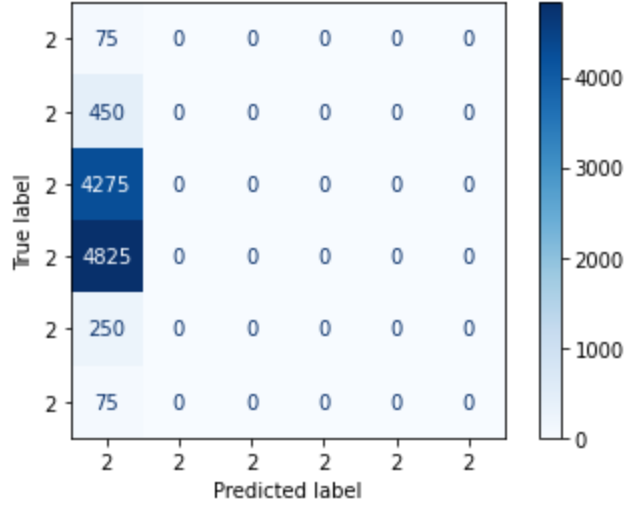

In [ ]:
# # # BEST BINARY - 46%

# num_classes = 2

# stock_model = keras.Sequential([
#     Embedding(vocab_size + 1, 64, input_length=max_len),
#     LSTM(units=96, input_shape=(X_train_array.shape[0], X_train_array.shape[1]), return_sequences=True),
#     LSTM(units=32),
#     #BatchNormalization(),
#     Dropout(0.05),
#     Dense(units=16, activation='relu'),
#     #BatchNormalization(),
#     Dropout(0.05),
#     Dense(units=8, activation='relu'),
#     #BatchNormalization(),
#     Dropout(0.05),
#     Dense(units=num_classes, activation='softmax')
# ])

# stock_model.summary()

# callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)

# # checkpoint_filepath = r'C:\Users\AravSanthanam\Polygence_2022\mdcheckpoints'
# # model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
# #     filepath=checkpoint_filepath,
# #     save_weights_only=True,
# #     monitor='val_accuracy',
# #     mode='max',
# #     save_best_only=True)

# # y_train_onehot = y_train_onehot.reshape(-1,1)
# # y_val_onehot = y_val_onehot.reshape(-1,1)

# adam_opt = keras.optimizers.Adam(learning_rate=0.0001)

# stock_model.compile(optimizer=adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])
# history = stock_model.fit(X_train_array, y_train_onehot, batch_size=4, epochs=1, validation_data=(X_val_array, y_val_onehot),
#                           class_weight=class_weights, shuffle=True, callbacks=[callback], verbose=1)

# #stock_model.load_weights(checkpoint_filepath)

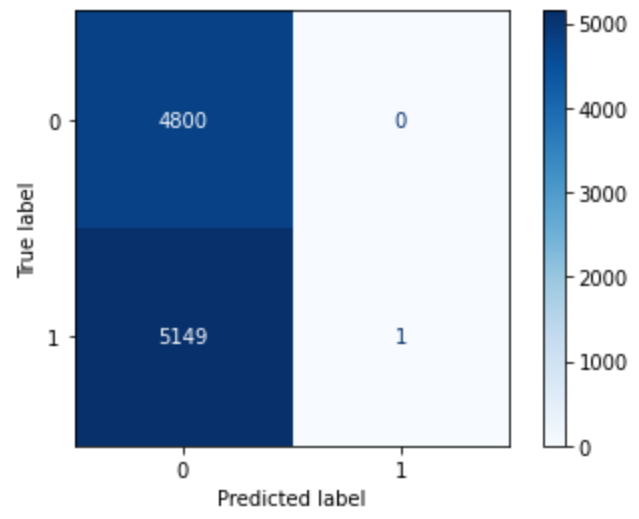